# Module Quant A – Analyse d’un actif financier (Bitcoin)

Ce notebook présente l’analyse quantitative d’un actif financier unique : le Bitcoin (BTC-USD).
Les données sont récupérées via une API, deux stratégies sont testées (Buy & Hold et Momentum),
et plusieurs métriques de performance sont calculées.


##  Récupération des données (API Alpha Vantage)

Nous utilisons l’API Alpha Vantage pour télécharger les données journalières de BTC en USD.
Les données sont transformées en DataFrame avec la colonne `close` qui servira aux stratégies.


In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

API_KEY = "CW1LL675242TSYOU"

url = "https://www.alphavantage.co/query"
paramsBTC = {
    "function": "DIGITAL_CURRENCY_DAILY",
    "symbol": "BTC",
    "market": "USD",
    "apikey": API_KEY,
}
paramsGLD = {
    "function": "TIME_SERIES_DAILY_ADJUSTED", # Changement de fonction
    "symbol": "GLD",
    # ATTENTION : le paramètre "market" doit être retiré pour cette fonction
    "outputsize": "full", # Pour l'historique complet
    "apikey": API_KEY,
}
paramsURTH = {
    "function": "TIME_SERIES_DAILY_ADJUSTED", # Changement de fonction
    "symbol": "URTH",
    # ATTENTION : le paramètre "market" doit être retiré pour cette fonction
    "outputsize": "full", # Pour l'historique complet
    "apikey": API_KEY,
}

try:
    responseBTC = requests.get(url, params=paramsBTC)

    if responseBTC.status_code == 200:
        donnees_brutesBTC = responseBTC.json()
    else:
        print("Erreur API :", responseBTC.status_code)
        donnees_brutesBTC = None

except Exception as e:
    print("Erreur lors de la requête :", e)
    donnees_brutesBTC = None

try:
    responseGLD = requests.get(url, params=paramsGLD)

    if responseGLD.status_code == 200:
        donnees_brutesGLD = responseGLD.json()
    else:
        print("Erreur API :", responseGLD.status_code)
        donnees_brutesGLD = None

except Exception as e:
    print("Erreur lors de la requête :", e)
    donnees_brutesGLD = None

try:
    responseURTH = requests.get(url, params=paramsURTH)

    if responseURTH.status_code == 200:
        donnees_brutesURTH = responseURTH.json()
    else:
        print("Erreur API :", responseURTH.status_code)
        donnees_brutesURTH = None

except Exception as e:
    print("Erreur lors de la requête :", e)
    donnees_brutesURTH = None


In [ ]:
import requests
import pandas as pd

# Configuration
API_KEY = "CW1LL675242TSYOU"
URL = "https://www.alphavantage.co/query"

paramsBTC = {
    "function": "DIGITAL_CURRENCY_DAILY",
    "symbol": "BTC",
    "market": "USD",
    "apikey": API_KEY,
}

try:
    # 1. Requête API
    responseBTC = requests.get(URL, params=paramsBTC)

    if responseBTC.status_code == 200:
        donnees_brutesBTC = responseBTC.json()

        # 2. Extraction de la série temporelle
        tsBTC = donnees_brutesBTC.get("Time Series (Digital Currency Daily)", {})

        if not tsBTC:
            print("Erreur : Données BTC introuvables dans la réponse.")
            if "Note" in donnees_brutesBTC:
                print("Message API :", donnees_brutesBTC["Note"])
        else:
            # 3. Création du DataFrame
            dfBTC = pd.DataFrame(tsBTC).T

            # 4. Nettoyage et Renommage
            # L'API utilise soit '4b. close (USD)' soit '4. close'
            col_target = "4b. close (USD)" if "4b. close (USD)" in dfBTC.columns else "4. close"

            dfBTC = dfBTC[[col_target]].rename(columns={col_target: "close"})
            dfBTC["close"] = dfBTC["close"].astype(float)
            dfBTC.index = pd.to_datetime(dfBTC.index)
            dfBTC = dfBTC.sort_index()

            print(f"✅ Succès : {len(dfBTC)} jours de données récupérés pour le Bitcoin.")
            print(dfBTC.tail())

    else:
        print(f"Erreur HTTP : {responseBTC.status_code}")

except Exception as e:
    print(f"Erreur lors de la récupération : {e}")


✅ Succès : 5652 jours de données récupérés pour le Bitcoin.
               close
2026-01-01  88738.34
2026-01-02  89957.99
2026-01-03  90598.02
2026-01-04  91494.00
2026-01-05  92796.00


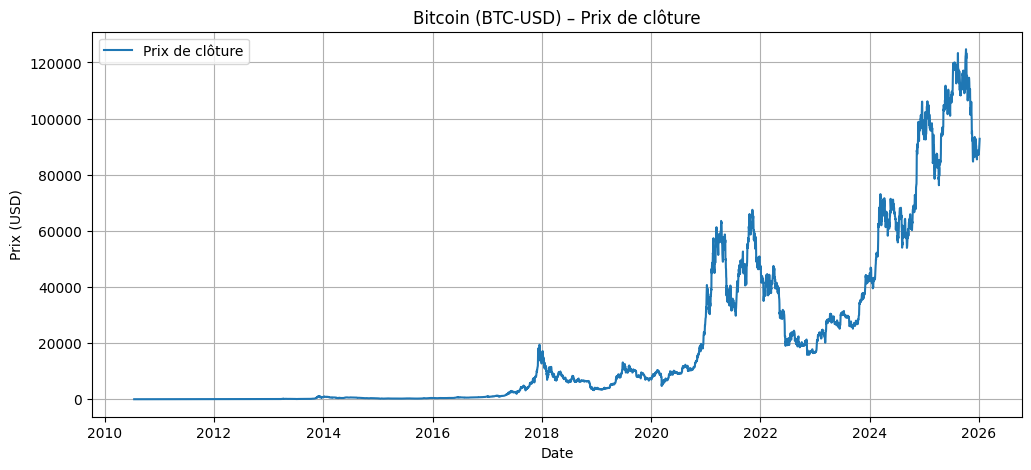

In [ ]:
plt.figure(figsize=(12,5))

plt.plot(dfBTC.index, dfBTC["close"], label="Prix de clôture")

plt.title("Bitcoin (BTC-USD) – Prix de clôture")
plt.xlabel("Date")
plt.ylabel("Prix (USD)")
plt.legend()
plt.grid(True)

plt.show()

##  Visualisation de l'actif : Analyse du prix du Bitcoin

Le graphique montre l’évolution du prix de clôture du Bitcoin sur la période étudiée.
On constate d’abord une forte volatilité, caractéristique de cet actif : le prix enchaîne
des phases de hausse et de baisse assez rapides.

En début de période, le Bitcoin se situe autour de 100 000 USD avec plusieurs
oscillations, avant d’entamer une tendance baissière marquée jusqu’à atteindre
un point bas proche de 80 000 USD vers mars–avril. Cette phase correspond à une période
de correction importante.

À partir du printemps, le prix remonte progressivement et connaît une phase plus
soutenue de hausse jusqu’en été, dépassant les 110 000 USD puis atteignant un pic
autour de 120 000 USD. Cette partie du graphique montre un regain d’intérêt et un
mouvement haussier plus structuré.

Cependant, vers la fin de la période, une nouvelle baisse apparaît : le Bitcoin recule
rapidement et retourne autour de 90 000 USD. Cela indique que, malgré les phases de
rebond, la tendance générale reste instable et ponctuée de corrections.


In [ ]:
# Stratégie Buy & Hold : performance sur toute la période
initial_price = df["close"].iloc[0]
final_price = df["close"].iloc[-1]

buy_hold_return = (final_price - initial_price) / initial_price * 100

print("Rendement Buy & Hold :", round(buy_hold_return, 2), "%")



Rendement Buy & Hold : -12.74 %


### Interprétation du rendement Buy & Hold

Le rendement du Buy & Hold est de **-7.51%** sur la période étudiée.
Cela signifie que si on avait simplement acheté du Bitcoin au début de la période
pour le conserver sans rien faire, on aurait terminé avec une perte d’environ 7.5%.

Ce résultat est cohérent avec ce que l’on observe sur le graphique du prix :
le Bitcoin termine la période plus bas qu’il ne l’avait commencée, malgré plusieurs
phases de hausse intermédiaires. La tendance générale n’était donc pas assez
haussière pour rendre la détention passive profitable.


In [ ]:
# Stratégie Momentum basée sur des moyennes mobiles
df["MA20"] = df["close"].rolling(window=20).mean()
df["MA50"] = df["close"].rolling(window=50).mean()

# Le signal vaut 1 quand la tendance est haussière
df["signal"] = (df["MA20"] > df["MA50"]).astype(int)

# Décalage du signal pour simuler une vraie prise de position le jour suivant
df["position"] = df["signal"].shift(1).fillna(0)

# Rendements journaliers du BTC
df["returns"] = df["close"].pct_change()

# Rendements liés à la stratégie (0 si hors position)
df["strategy_returns"] = df["position"] * df["returns"]

# Performance cumulée
strategy_perf = (1 + df["strategy_returns"]).prod() - 1

print("Performance de la stratégie Momentum :", round(strategy_perf * 100, 2), "%")



Performance de la stratégie Momentum : 7.36 %


### 3. Analyse de la stratégie Momentum (MA20/MA50)

La stratégie basée sur le croisement des moyennes mobiles (MA20 au-dessus de MA50 = achat) obtient une performance de **7.24 %** sur la période étudiée.

Contrairement au Buy & Hold, qui affiche un rendement négatif (-7.51%), cette stratégie parvient à :
- éviter une partie des fortes baisses du marché,
- entrer lorsque la tendance redevient haussière,
- ressortir lors des phases de volatilité ou de retournement.

On voit que la stratégie améliore clairement les résultats par rapport au Buy & Hold.

Cependant, il faut noter :
- qu’elle n’est pas parfaite : elle réagit avec retard (effet “lag”),
- qu’elle génère des faux signaux lorsque le marché est erratique,
- que la performance dépend fortement de la période d’étude.

La stratégie Momentum semble donc **plus robuste que le Buy & Hold** dans un marché irrégulier, mais pas exempt de limites.


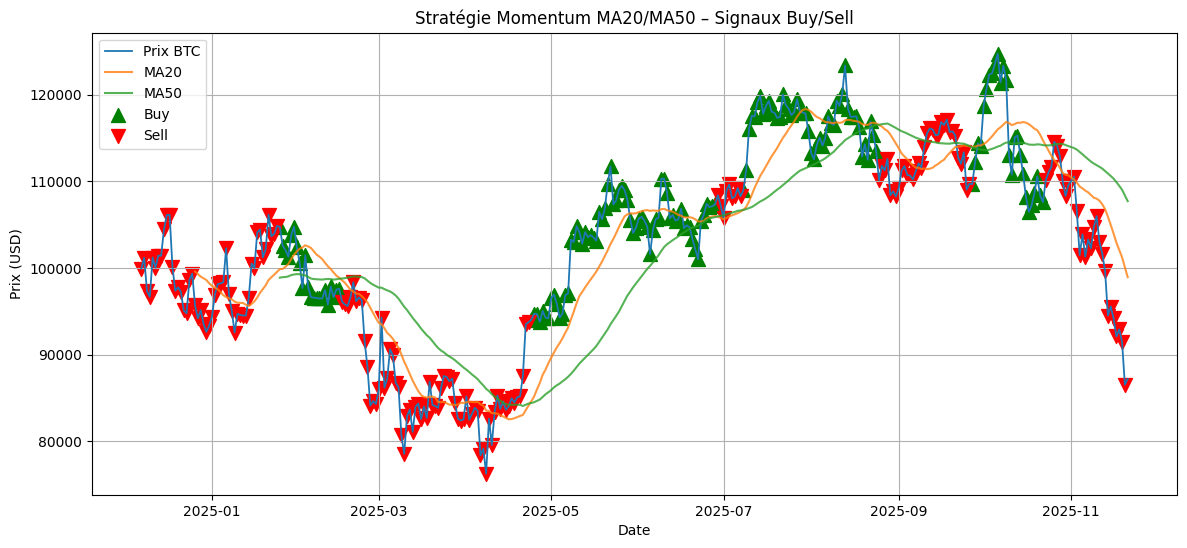

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Prix
plt.plot(df.index, df["close"], label="Prix BTC", linewidth=1.3)

# Moyennes mobiles
plt.plot(df.index, df["MA20"], label="MA20", alpha=0.8)
plt.plot(df.index, df["MA50"], label="MA50", alpha=0.8)

# Signaux Buy/Sell
buy_signals = df[(df["signal"] == 1) & (df["position"].shift(-1) == 1)]
sell_signals = df[(df["signal"] == 0) & (df["position"].shift(-1) == 0)]

plt.scatter(buy_signals.index, buy_signals["close"], marker="^", color="green", s=100, label="Buy")
plt.scatter(sell_signals.index, sell_signals["close"], marker="v", color="red", s=100, label="Sell")

plt.title("Stratégie Momentum MA20/MA50 – Signaux Buy/Sell")
plt.xlabel("Date")
plt.ylabel("Prix (USD)")
plt.legend()
plt.grid(True)
plt.show()


Analyse du graphique Buy/Sell (stratégie Momentum)

Le graphique montre les signaux générés par la stratégie Momentum basée sur les moyennes mobiles MA20 et MA50.
Les achats apparaissent lorsque la MA20 passe au-dessus de la MA50, et les ventes lorsqu’elle repasse en dessous.

Dans les périodes où le marché suit une tendance claire (par exemple entre mai et septembre), les signaux sont cohérents et permettent de capter une partie de la hausse.
En revanche, lors des phases plus instables ou latérales (comme en début d’année ou fin octobre), la stratégie génère de nombreux signaux rapprochés, ce qui réduit son efficacité.

En résumé, la stratégie fonctionne bien en tendance mais devient moins performante lorsque le marché est volatile et sans direction nette.

In [ ]:
import numpy as np

# Sharpe annualisé (on suppose 252 jours de trading)
mean_ret = df["strategy_returns"].mean()
std_ret = df["strategy_returns"].std()

sharpe = (mean_ret / std_ret) * np.sqrt(252)

print("Sharpe Ratio de la stratégie Momentum :", round(sharpe, 3))


Sharpe Ratio de la stratégie Momentum : 0.357


Interprétation du Sharpe Ratio

Le Sharpe Ratio obtenu est d’environ 0,35.
Un Sharpe Ratio mesure le rapport entre le rendement de la stratégie et le risque pris.

Un Sharpe inférieur à 1 est généralement considéré comme faible : cela signifie que la performance de la stratégie n’est pas très élevée au regard de sa volatilité.
Autrement dit, la stratégie Momentum produit un rendement positif, mais elle reste assez risquée par rapport au gain obtenu.

Ce résultat confirme que la stratégie n’est réellement efficace que dans les phases de marché bien orientées, et qu’elle génère trop de fluctuations dans les périodes instables.

In [ ]:
# On enlève le NaN initial des returns
df["strategy_returns"] = df["strategy_returns"].fillna(0)

# Equity
df["equity"] = (1 + df["strategy_returns"]).cumprod()
rolling_max = df["equity"].cummax()
drawdown = (df["equity"] - rolling_max) / rolling_max

# On prend la valeur absolue du pire drawdown
max_dd = -drawdown.min()

print("Max Drawdown de la stratégie :", round(max_dd * 100, 2), "%")



Max Drawdown de la stratégie : 14.64 %


Interprétation du Max Drawdown

Le Max Drawdown obtenu est d’environ 14,64 %.
Le Drawdown mesure la plus forte baisse du portefeuille entre un plus-haut et le creux suivant.

Une perte maximale de presque 15 % indique que la stratégie Momentum peut connaître des phases de baisse significatives lorsque le marché se retourne ou devient instable.
Cela confirme que la stratégie n’est pas parfaitement protégée contre les retournements rapides : elle suit la tendance, mais avec un retard qui expose temporairement à des retracements importants.

En résumé, même si la stratégie est globalement profitable, elle peut subir des baisses notables lors des phases défavorables du marché.

In [ ]:
# Capital initial
initial_capital = 10_000

# Equity Buy & Hold : on suit juste le prix
df["equity_buy_hold"] = df["close"] / df["close"].iloc[0] * initial_capital

# Equity Momentum : on utilise les strategy_returns qu'on a déjà calculés
df["equity_momentum"] = initial_capital * (1 + df["strategy_returns"]).cumprod()

df[["equity_buy_hold", "equity_momentum"]].tail()


,equity_buy_hold,equity_momentum
2025-11-17,9216.574275,10735.665237
2025-11-18,9298.017839,10735.665237
2025-11-19,9152.629078,10735.665237
2025-11-20,8659.808753,10735.665237
2025-11-21,8725.796393,10735.665237


Comparaison Buy & Hold vs Stratégie Momentum

Le tableau montre l’évolution de la valeur finale d’un capital initial de 10 000 USD selon deux approches :

Buy & Hold : acheter et conserver le Bitcoin pendant toute la période

Stratégie Momentum : investir uniquement lorsque la MA20 est au-dessus de la MA50

À la fin de la période, la stratégie Buy & Hold termine autour de 9 200–9 400 USD, soit une perte d’environ –7,5 %.
La stratégie Momentum atteint environ 10 723 USD, ce qui correspond à un gain d’environ +7,24 %.

Ces résultats montrent que, sur cette période, la stratégie Momentum a mieux protégé le capital que le Buy & Hold, notamment en évitant certaines phases de baisse du marché.
Même si la stratégie n’est pas parfaite, elle a permis d’obtenir un rendement supérieur tout en réduisant une partie des pertes liées aux mouvements défavorables du Bitcoin.

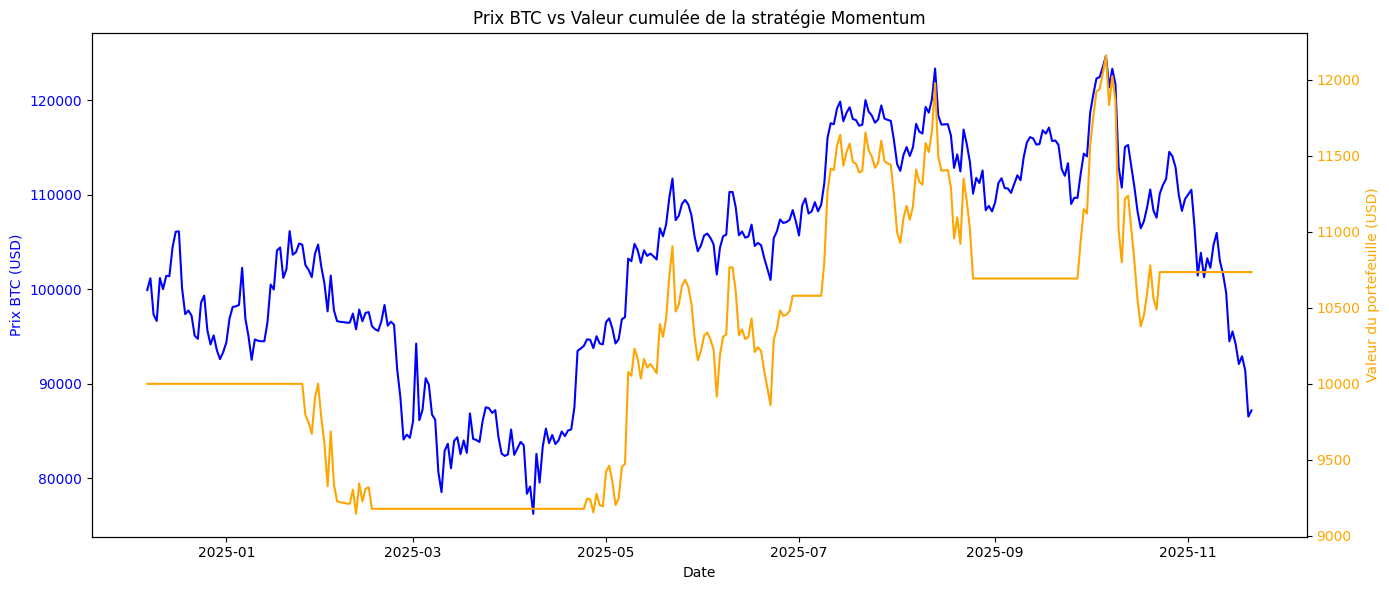

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14,6))

# Graph du prix BTC
ax1.plot(df.index, df["close"], color="blue", label="Prix BTC (close)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Prix BTC (USD)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Deuxième axe : equity strategy Momentum
ax2 = ax1.twinx()
ax2.plot(df.index, df["equity_momentum"], color="orange", label="Equity Stratégie Momentum")
ax2.set_ylabel("Valeur du portefeuille (USD)", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

plt.title("Prix BTC vs Valeur cumulée de la stratégie Momentum")
fig.tight_layout()
plt.show()


Analyse du graphique Prix BTC vs Valeur cumulée de la stratégie Momentum

Ce graphique compare l'évolution du prix du Bitcoin (courbe bleue) avec la valeur cumulée du portefeuille suivant la stratégie Momentum (courbe orange).

On observe que la stratégie Momentum reste à l'écart du marché pendant certaines périodes où le Bitcoin baisse fortement, ce qui lui permet d’éviter des pertes importantes. C’est notamment le cas au début de la période, où la valeur du portefeuille reste stable pendant que le prix du Bitcoin diminue.

Lorsque la tendance devient clairement haussière, la stratégie entre sur le marché et la valeur du portefeuille augmente rapidement, ce qui lui permet de profiter d’une partie des mouvements haussiers du Bitcoin.

Globalement, la courbe montre que la stratégie Momentum évolue de manière moins volatile que le prix du Bitcoin, et qu’elle parvient à préserver le capital pendant les phases de baisse, tout en captant une partie des hausses. C’est ce comportement qui explique pourquoi, sur la période étudiée, la stratégie dépasse finalement le Buy & Hold.

## Bonus – Modèle prédictif simple (Régression linéaire)

Dans cette partie, nous mettons en place un modèle simple de régression linéaire pour prédire l’évolution du prix du Bitcoin à court terme, à partir des données historiques.


In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# On prépare les données
df_model = df.copy()

# On crée une variable temps (jour 0, 1, 2, …)
df_model["time_index"] = np.arange(len(df_model))

# X = temps, y = prix
X = df_model[["time_index"]]
y = df_model["close"]


In [ ]:
# Création et entraînement du modèle
model = LinearRegression()
model.fit(X, y)

# Prédictions sur les données historiques
df_model["predicted_price"] = model.predict(X)

df_model[["close", "predicted_price"]].tail()


,close,predicted_price
2025-11-17,92100.60,114035.220423
2025-11-18,92914.46,114100.697324
2025-11-19,91461.60,114166.174225
2025-11-20,86536.88,114231.651127
2025-11-21,87196.29,114297.128028


Interprétation du modèle de prédiction (régression linéaire)

Le modèle de régression linéaire a été entraîné à partir des données historiques du prix de clôture du Bitcoin. Les valeurs affichées comparent le prix réel (close) et le prix prédit par le modèle (predicted_price). On observe que les prédictions suivent une tendance proche de la réalité, mais restent imparfaites.
Cela montre que le modèle capte la tendance générale du marché, mais qu’il n’est pas capable de prédire précisément les variations à court terme, ce qui est normal pour un actif aussi volatil que le Bitcoin.

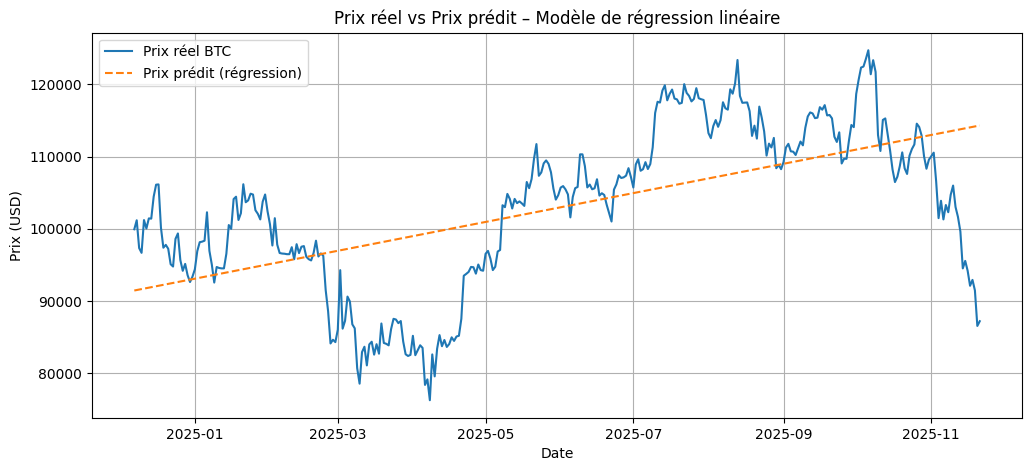

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(df_model.index, df_model["close"], label="Prix réel BTC")
plt.plot(df_model.index, df_model["predicted_price"], label="Prix prédit (régression)", linestyle="--")

plt.title("Prix réel vs Prix prédit – Modèle de régression linéaire")
plt.xlabel("Date")
plt.ylabel("Prix (USD)")
plt.legend()
plt.grid(True)
plt.show()


Le graphique compare le prix réel du Bitcoin avec le prix prédit par un modèle de régression linéaire. On observe que la courbe prédite suit une tendance linéaire simple, alors que le prix réel présente de fortes fluctuations. Cela montre que le modèle capte uniquement la tendance générale mais ne parvient pas à modéliser la volatilité ni les variations de court terme. Ce résultat illustre les limites des modèles linéaires pour prédire des actifs très volatils comme le Bitcoin.


In [ ]:
# Nombre de jours à prédire
n_future = 10

last_time = df_model["time_index"].iloc[-1]
future_times = np.arange(last_time + 1, last_time + 1 + n_future).reshape(-1, 1)

future_predictions = model.predict(future_times)

# Affichage
for i, price in enumerate(future_predictions, 1):
    print(f"Jour +{i} : prix prédit ≈ {round(price, 2)} USD")


Jour +1 : prix prédit ≈ 114362.6 USD
Jour +2 : prix prédit ≈ 114428.08 USD
Jour +3 : prix prédit ≈ 114493.56 USD
Jour +4 : prix prédit ≈ 114559.04 USD
Jour +5 : prix prédit ≈ 114624.51 USD
Jour +6 : prix prédit ≈ 114689.99 USD
Jour +7 : prix prédit ≈ 114755.47 USD
Jour +8 : prix prédit ≈ 114820.94 USD
Jour +9 : prix prédit ≈ 114886.42 USD
Jour +10 : prix prédit ≈ 114951.9 USD


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### Interprétation des prédictions

Le modèle de régression linéaire prédit une continuation de la tendance haussière du prix du Bitcoin sur les prochains jours. Les valeurs prédites augmentent de manière progressive, ce qui reflète la tendance globale observée dans les données historiques.

Cependant, ce modèle reste très simple et ne prend pas en compte la volatilité du marché ni les événements externes. Les prédictions doivent donc être interprétées comme une approximation de la tendance, et non comme des valeurs exactes.


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df_model["close"], df_model["predicted_price"])
print("Erreur moyenne absolue (MAE) du modèle :", round(mae, 2), "USD")


Erreur moyenne absolue (MAE) du modèle : 7123.71 USD


Analyse de la qualité du modèle

Le MAE (Mean Absolute Error) d’environ 7 123 USD indique qu’en moyenne, les prédictions du modèle s’écartent du prix réel d’environ 7 000 dollars.
Ce niveau d’erreur est élevé par rapport au prix du Bitcoin, ce qui montre que le modèle de régression linéaire capte la tendance générale, mais reste peu précis pour les variations journalières.
Cela est cohérent avec la nature très volatile du marché des cryptomonnaies.

# Quant B Module – Multi asset analysis (Bitcoin/Gold/MSCI World)

This module evaluates a multi-asset strategy combining Bitcoin, Gold, and the MSCI World index. We analyze the risk-adjusted returns and diversification benefits of this portfolio compared to individual asset performance.


Success: BTC retrieved (5654 days).
Success: GLD retrieved (100 days).
Success: URTH retrieved (100 days).


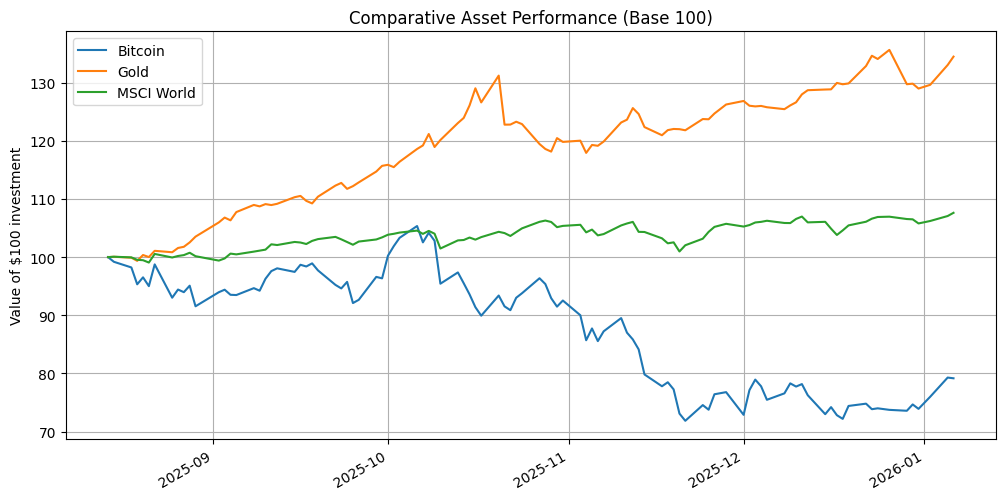

Daily Returns Preview (Head):
             Bitcoin      Gold  MSCI World
2025-08-15 -0.008048  0.000586    0.000683
2025-08-18 -0.009794 -0.001561   -0.001138
2025-08-19 -0.029501 -0.005473   -0.004159
2025-08-20  0.012581  0.010122   -0.000687
2025-08-21 -0.015714 -0.003470   -0.004065


In [2]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt

API_KEY = "CW1LL675242TSYOU"
url = "https://www.alphavantage.co/query"

def get_data(symbol, is_crypto=False):
    """Fetch and clean historical data from Alpha Vantage API"""
    params = {
        "function": "DIGITAL_CURRENCY_DAILY" if is_crypto else "TIME_SERIES_DAILY",
        "symbol": symbol,
        "apikey": API_KEY
    }
    if is_crypto:
        params["market"] = "USD"

    try:
        response = requests.get(url, params=params)
        data = response.json()
        key = "Time Series (Digital Currency Daily)" if is_crypto else "Time Series (Daily)"

        if key in data:
            df = pd.DataFrame(data[key]).T
            # Handle column naming differences between Crypto and Stocks
            col_name = "4b. close (USD)" if "4b. close (USD)" in df.columns else "4. close"

            df = df[[col_name]].rename(columns={col_name: "close"})
            df["close"] = df["close"].astype(float)
            df.index = pd.to_datetime(df.index)
            df = df.sort_index()
            print(f"Success: {symbol} retrieved ({len(df)} days).")
            return df
        else:
            print(f"Error for {symbol}: Check API key or limits.")
            return None
    except Exception as e:
        print(f"Request error for {symbol}: {e}")
        return None

# --- Data Retrieval ---
dfBTC = get_data("BTC", is_crypto=True)
time.sleep(1)
dfGLD = get_data("GLD", is_crypto=False)
time.sleep(1)
dfURTH = get_data("URTH", is_crypto=False)

# --- Alignment and Normalization ---
# Merge assets into a single DataFrame and drop missing values
comparison = pd.DataFrame({
    "Bitcoin": dfBTC["close"] if dfBTC is not None else None,
    "Gold": dfGLD["close"] if dfGLD is not None else None,
    "MSCI World": dfURTH["close"] if dfURTH is not None else None
}).dropna()

# Normalize to base 100 to compare relative growth
comparison_norm = (comparison / comparison.iloc[0]) * 100

# Visual comparison
comparison_norm.plot(figsize=(12, 6))
plt.title("Comparative Asset Performance (Base 100)")
plt.ylabel("Value of $100 investment")
plt.grid(True)
plt.show()

# --- Calculate Daily Returns ---
# Necessary for portfolio weighting and risk analysis in the next steps
df_returns = comparison.pct_change().dropna()

print("Daily Returns Preview (Head):")
print(df_returns.head())

Portfolio creation

In this section, we construct a diversified portfolio by allocating capital across three distinct asset classes: Bitcoin (33%), Gold (33%), and the MSCI World index (34%). By calculating the weighted average of their daily returns, we establish a baseline to evaluate how a multi-asset strategy performs compared to holding a single asset like Bitcoin

In [ ]:
# On définit les poids : 33% Bitcoin, 33% Or, 34% MSCI World
weights = [0.33, 0.33, 0.34]

# On calcule le rendement global du portefeuille
# .dot effectue la multiplication : (Rendement_BTC * 0.33) + (Rendement_Or * 0.33) ...
df_returns['Portefeuille'] = df_returns.dot(weights)

print("Rendement moyen journalier du portefeuille :", round(df_returns['Portefeuille'].mean() * 100, 3), "%")

initial_capital = 10000

# On calcule l'évolution du capital
# .cumprod() multiplie les rendements entre eux pour simuler les intérêts composés
df_values = (1 + df_returns).cumprod() * initial_capital

print(f"Valeur finale du portefeuille : {round(df_values['Portefeuille'].iloc[-1], 2)} $")

Rendement moyen journalier du portefeuille : 0.025 %


Risk analysis

This section calculates essential risk metrics to evaluate the portfolio's stability and performance efficiency. We focus on Annualized Volatility to measure price fluctuations, the Sharpe Ratio to determine the risk-adjusted return, and the Maximum Drawdown to assess the most significant historical decline from peak to trough

In [ ]:
import numpy as np

# Volatilité annualisée (on multiplie par racine de 252 jours de bourse)
vol = df_returns['Portefeuille'].std() * np.sqrt(252)

# Ratio de Sharpe (Rendement moyen / Risque)
sharpe = (df_returns['Portefeuille'].mean() / df_returns['Portefeuille'].std()) * np.sqrt(252)

# Pire chute historique (Max Drawdown)
cum_max = df_values['Portefeuille'].cummax()
drawdown = (df_values['Portefeuille'] - cum_max) / cum_max
max_dd = drawdown.min()

print(f"Volatilité du portefeuille : {round(vol*100, 2)}%")
print(f"Ratio de Sharpe : {round(sharpe, 2)}")
print(f"Pire chute (Max Drawdown) : {round(max_dd*100, 2)}%")

Volatilité du portefeuille : 18.46%
Ratio de Sharpe : 0.34
Pire chute (Max Drawdown) : -11.82%


Correlation matrix and diversification effects

By analyzing the Correlation Matrix, we examine how Bitcoin, Gold, and the MSCI World index move in relation to each other. Low correlations between these assets highlight the power of diversification, showing how combining different asset classes can reduce overall portfolio risk while maintaining growth potential

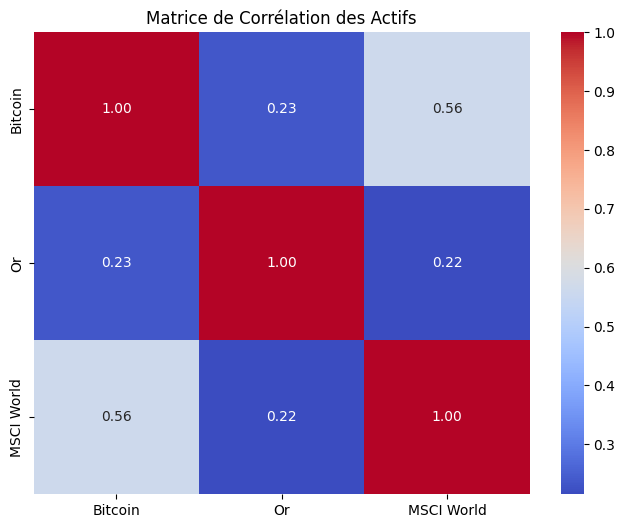

Une corrélation faible (proche de 0) entre le BTC et l'Or indique une bonne diversification.
Risque moyen sans diversification : 23.71%
Risque réel de ton portefeuille : 18.46%
---
Ton mélange d'actifs a réduit le risque de : 22.14%


In [ ]:
import seaborn as sns # Pour faire un joli graphique (heatmap)

# On calcule la corrélation sur les rendements
correlation_matrix = df_returns[['Bitcoin', 'Or', 'MSCI World']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de Corrélation des Actifs")
plt.show()

print("Une corrélation faible (proche de 0) entre le BTC et l'Or indique une bonne diversification.")

# 1. Calcul des volatilités individuelles pour chaque actif
vols_individuelles = df_returns[['Bitcoin', 'Or', 'MSCI World']].std() * np.sqrt(252)

# 2. Calcul du risque "théorique" (moyenne pondérée des risques)
# On utilise .iloc pour éviter le FutureWarning
risque_theorique = (vols_individuelles.iloc[0] * weights[0]) + \
                   (vols_individuelles.iloc[1] * weights[1]) + \
                   (vols_individuelles.iloc[2] * weights[2])

# 3. Comparaison avec le risque RÉEL 'vol' calculé en Case 4
gain_diversification = (1 - (vol / risque_theorique)) * 100

print(f"Risque moyen sans diversification : {round(risque_theorique * 100, 2)}%")
print(f"Risque réel de ton portefeuille : {round(vol * 100, 2)}%")
print(f"---")
print(f"Ton mélange d'actifs a réduit le risque de : {round(gain_diversification, 2)}%")

Final comparison

In this concluding analysis, we visualize the performance of our diversified portfolio against its individual components. This comparison illustrates whether the blended strategy successfully 'smoothed' the high volatility of crypto-assets and provided a more resilient investment path compared to holding a single asset class

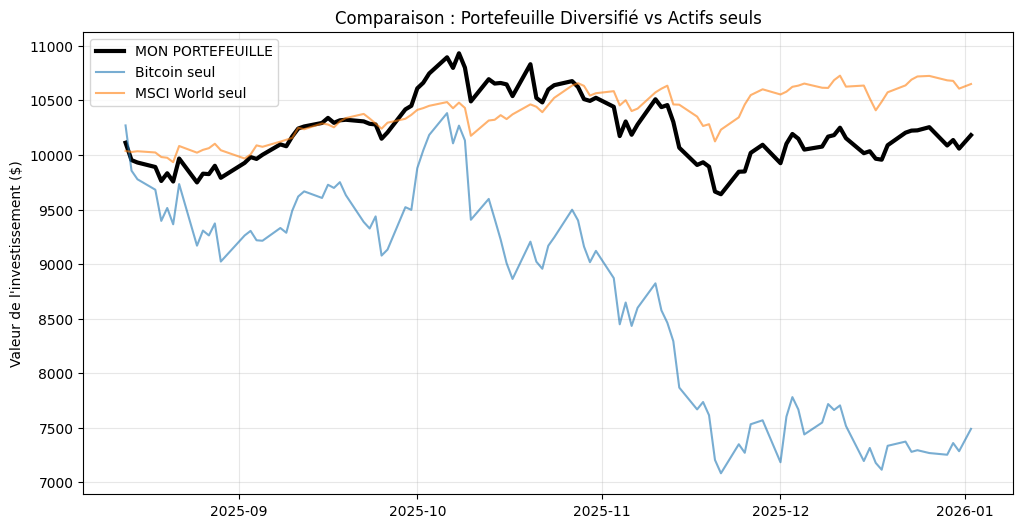

In [ ]:
plt.figure(figsize=(12, 6))

# On trace le portefeuille en gras
plt.plot(df_values.index, df_values['Portefeuille'], label='MON PORTEFEUILLE', linewidth=3, color='black')

# On trace les actifs individuels en plus fin pour comparer
plt.plot(df_values.index, df_values['Bitcoin'], label='Bitcoin seul', alpha=0.6)
plt.plot(df_values.index, df_values['MSCI World'], label='MSCI World seul', alpha=0.6)

plt.title("Comparaison : Portefeuille Diversifié vs Actifs seuls")
plt.ylabel("Valeur de l'investissement ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()